In [1]:
import os

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from pandas.tseries.frequencies import to_offset

In [2]:
data_dir = "./Data/"
print(*os.listdir(data_dir), sep="\n")

PricesFile1.csv
NG_ImpliedVols2020.csv
NG_Unified.csv
NG_ImpliedVols2022.csv
AECO_Unified.csv
NG_ImpliedVols2021.csv
WTI_ImpliedVols2022.csv
WTI_ImpliedVols2020.csv
WTI_ImpliedVols2021.csv
InterestRates.csv


In [4]:
NG_df = pd.read_csv(data_dir+"NG_Unified.csv")
NG_df.t, NG_df["T"] = pd.to_datetime(NG_df.t), pd.to_datetime(NG_df["T"])
NG_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152776 entries, 0 to 152775
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   t       152776 non-null  datetime64[ns]
 1   T       152776 non-null  datetime64[ns]
 2   F       152776 non-null  float64       
 3   K       152776 non-null  float64       
 4   sigma   152776 non-null  float64       
 5   r       152776 non-null  float64       
dtypes: datetime64[ns](2), float64(4)
memory usage: 7.0 MB


In [20]:
sample_df = NG_df.loc[(pd.Timedelta("10 days") < (NG_df["T"] - NG_df.t))]
sample_t = ["2020-03-02", "2020-04-20", "2020-05-01", "2020-05-29"]
sample_df = sample_df.loc[sample_df.t.isin(sample_t)]
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9637 entries, 0 to 152775
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   t       9637 non-null   datetime64[ns]
 1   T       9637 non-null   datetime64[ns]
 2   F       9637 non-null   float64       
 3   K       9637 non-null   float64       
 4   sigma   9637 non-null   float64       
 5   r       9637 non-null   float64       
dtypes: datetime64[ns](2), float64(4)
memory usage: 527.0 KB


In [18]:
def tune(F_vect, delta):
    if type(F_vect) != np.ndarray:
        raise TypeError("Must be numpy array.")
    
    n = len(F_vect) - 1
    
    x, y = F_vect[0:-1], F_vect[1:]
    
    s_x, s_y = np.sum(x), np.sum(y)
    
    s_xx = np.sum(x ** 2)
    s_xy = np.sum(x * y)
    s_yy = np.sum(y ** 2)
    
    a = (n * s_xy - s_x * s_y) / (n * s_xx - s_x **2)
    b = (s_y - a * s_x) / n
    sd = np.sqrt((n * s_yy - s_y ** 2 - a * (n * s_xy - s_x * s_y)) / (n * (n-2)))
    
    lambda_par = - np.log(a) / delta
    mu = b / (1 - a)
    sigma = sd * np.sqrt(-2 * np.log(a) / (delta * (1 - a ** 2)))
    
    return mu, lambda_par, sigma

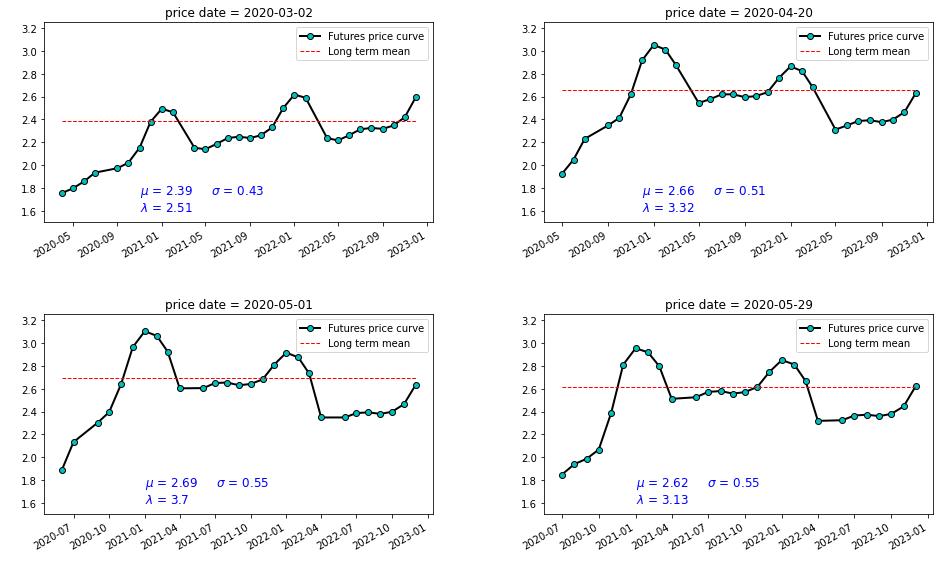

In [22]:
fig1 = plt.figure(constrained_layout=False)

spec1 = fig1.add_gridspec(ncols=2, nrows=2)

f1_ax1 = fig1.add_subplot(spec1[0, 0])
f1_ax2 = fig1.add_subplot(spec1[0, 1])
f1_ax3 = fig1.add_subplot(spec1[1, 0])
f1_ax4 = fig1.add_subplot(spec1[1, 1])

ax1_list = [f1_ax1, f1_ax2, f1_ax3, f1_ax4]

fig1.set_size_inches(15, 10)
fig1.tight_layout(pad=8)

for i in range(4):
    futures_curve_df = sample_df[["t", "T", "F"]].groupby("t").get_group(sample_t[i]).groupby("T").mean()
    
    F_vect = futures_curve_df.F.to_numpy()
    mu, lambda_par, sigma = tune(F_vect, 1/12)
    futures_curve_df["mu"] = mu
    
    futures_curve_df.reset_index().plot(ax=ax1_list[i], x="T", y="F", legend=True, xlabel=" ", ylabel=" ",
    style="ko-", markerfacecolor="c", linewidth=2, ylim=(1.5, 3.25))
    
    futures_curve_df.reset_index().plot(ax=ax1_list[i], x="T", y="mu", legend=True, xlabel=" ",
    ylabel=" ", style="r--", linewidth=1)

    x = futures_curve_df.index[6]
    y = 1.6
    ax1_list[i].text(x, y, "$\lambda$ = "+str(np.around(lambda_par, 2)), size=12,
    color="b")
    
    ax1_list[i].text(x, y+0.15, "$\mu$ = "+str(np.around(mu, 2))+"\t $\sigma$ = "+str(np.around(sigma, 2)), size=12,
    color="b")    
    
    ax1_list[i].legend(["Futures price curve", "Long term mean"], loc="upper right")
    ax1_list[i].set_title("price date = " + str(sample_t[i]))
    
plt.savefig("sample.jpg")

In [420]:
def CTGM_path_gen(lamdba_par, mu, t, T, F_init, sigma, n=10):
    
    path = np.zeros(n)
    ttm = T - t
    dt = (ttm / (n * 365))
    
    path[0] = F_init
    
    for i in range(n - 1):
        path[i+1] = path[i] + lambda_par * (mu - path[i]) * dt + sigma * np.sqrt(dt) * path[i] * np.random.randn()
    return path